In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import xarray as xa
from pprint import pprint

fdir = "/home/jungyoung/Project_win/hh_neuralnet/"

import sys
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools

import hhclustering as hc
import utils 

from importlib import reload
reload(utils)

from tqdm.notebook import tqdm, trange
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score
from numba import njit

In [160]:
# Load dataset
tag = ""
feature_dims = (15, 15, 3, 16)
# feature_dims = (15, 15, 3, 5)

with open("./data/align_data_sub%s.pkl"%(tag), 'rb') as fp:
    align_data_sub = pkl.load(fp)
    
data = align_data_sub["data"].copy()
echelon = np.array([c["rank"] for c in align_data_sub["col_names"]])

# PCA projected datset
eval, evec, _, cov_mat = hc.pca(data)
pca_proj = np.dot(evec.T, data)

def show_pca_proj(pred_labels, **kwargs):
    plt.scatter(pca_proj[0], pca_proj[1], c=pred_labels, s=1, **kwargs)

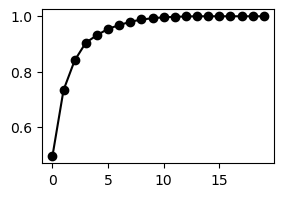

In [114]:
plt.figure(figsize=(3, 2))
plt.plot(np.cumsum(eval/np.sum(eval)), 'ko-')
plt.show()

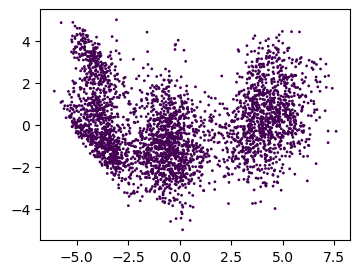

In [72]:
plt.figure(figsize=(4, 3))
show_pca_proj(np.zeros(pca_proj.shape[1]))
plt.show()

## remove lead-lag ratio

In [91]:
data_r = align_data_sub["data"][:-4]
row_labels_r = align_data_sub["row_labels"][:-4]

eval_r, evec_r, _, cov_mat = hc.pca(data_r)
pca_proj_r = np.dot(evec_r.T, data_r)

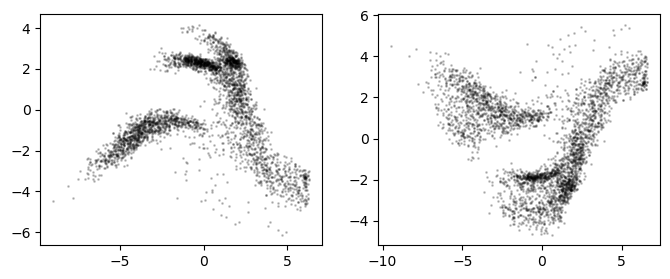

In [92]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.scatter(pca_proj_r[0], pca_proj_r[1], 1, 'k', facecolor="none", alpha=0.2)
plt.subplot(122)
plt.scatter(pca_proj[0], pca_proj[1], 1, 'k', facecolor="none", alpha=0.2)
plt.show()

## Check dynamics by index

In [119]:
def numel(arr):
    m = 1
    for n in range(len(arr)):
        m *= arr[n]
    return m

def get_sq_idx(idx):
    idx_set = []
    
    subt, div = 0, numel(feature_dims[1:])
    for n in range(4):
        nid = (idx - subt) // div        
        subt += div*nid
        div = numel(feature_dims[n+2:])
        idx_set.append(nid)
        
    
    # na = idx // numel(feature_dims[1:])
    # nb = (idx - numel(feature_dims[1:])*na) // numel(feature_dims[2:])
    # nr = (idx - 15*3*16*na - 3*16*nb) // 16
    # nw = idx - 15*3*16*na - 3*16*nb - 16*nr
    return idx_set


def get_idx(sq_idx):
    return sq_idx[0]*15*3*16 + sq_idx[1]*3*16 + sq_idx[2]*16 + sq_idx[3]

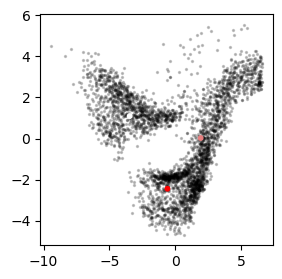

In [123]:
# target_idx = [3475, 7714, 7859]
target_idx = [500, 2000, 1200]

plt.figure(figsize=(3, 3))
plt.scatter(pca_proj[0], pca_proj[1],2, 'k', alpha=0.2, facecolor="none")
plt.scatter(pca_proj[0][target_idx], pca_proj[1][target_idx], 10, [[1, 0, 0], [0.9, 0.5, 0.5], [1, 1, 1]])
plt.show()

# plt.figure(figsize=(5, 3))
# for i in target_idx:
#     plt.plot(data[:, i], 'o-')
# plt.show()

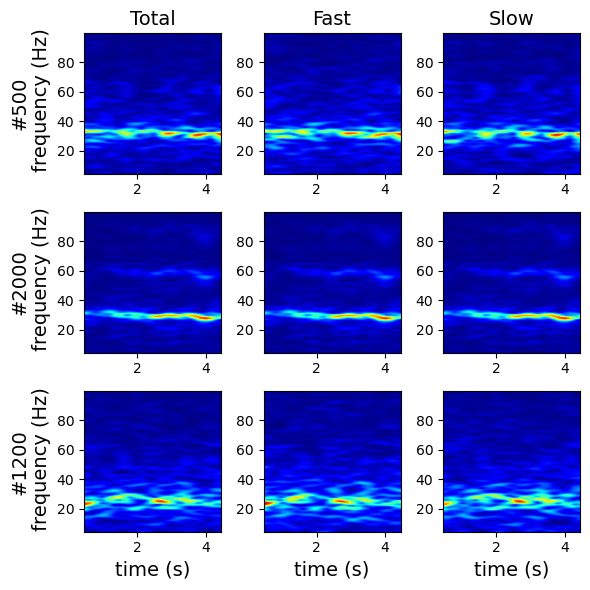

In [124]:
import sys
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools
import hhsignal

# summary = hhtools.SummaryLoader("../three_pop_mpi/simulation_data/data", load_only_control=True)
summary = hhtools.SummaryLoader("../mono_pop_mpi/simulation_data/data_slow/", load_only_control=True)

plt.figure(figsize=(6, 6))
nuse = 1
axs = []
for idx in target_idx:
    idx_sq = get_sq_idx(idx)
    detail = summary.load_detail(*idx_sq, 0)

    for v in detail["vlfp"]:
        psd, fpsd, tpsd = hhsignal.get_stfft(v, detail["ts"], 2000, frange=(5, 100))

        ax = plt.subplot(3, 3, nuse)
        hhtools.imshow_xy(psd, x=tpsd, y=fpsd, cmap="jet", interpolation="bicubic")
        
        nuse += 1
        axs.append(ax)

lbs = ("Total", "Fast", "Slow")
for i in range(3):
    axs[3*i].set_ylabel("#%d\n frequency (Hz)"%(target_idx[i]), fontsize=14)
    axs[6+i].set_xlabel("time (s)", fontsize=14)
    axs[i].set_title("%s"%(lbs[i]), fontsize=14)

plt.tight_layout()
plt.show()

# K-means clustering
Check after running explor_kmeans2.py

In [117]:
# load dataset
from sklearn.metrics import silhouette_score

# load result
# with open("./data/kmeans_pred.pkl", "rb") as fp:
# with open("./data/kmeans_pred_partial.pkl", "rb") as fp: # or kmeans_pred
with open("./data/kmeans_sub%s.pkl"%(tag), "rb") as fp: # or kmeans_pred
    pred_data = pkl.load(fp)
print(len(pred_data["labels"]))

1200


In [79]:
pred_data.keys()

dict_keys(['labels', 'inertia', 'silhouette', 'meta_info', 'nitr', 'k', 'fdata'])

## Determine optimal K

### Determine with inertia

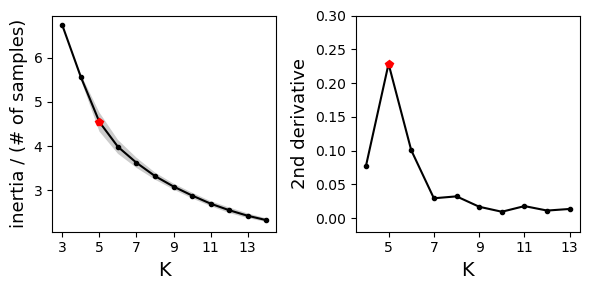

In [128]:
inertia = pred_data["inertia"].reshape([-1, pred_data["nitr"]]) / data.shape[1]
x = pred_data["k"]
m = inertia.mean(axis=1)
s = inertia.std(axis=1)
nopt = 2 # >= 1

plt.figure(figsize=(6, 3))

plt.subplot(121)
plt.plot(x, m, 'k.-')
plt.fill_between(x, m+s, m-s, color='k', edgecolor="none", alpha=0.2)
plt.xticks(np.arange(x[0], x[-1], 2))
plt.ylabel("inertia / (# of samples)", fontsize=13)
plt.xlabel("K", fontsize=14)
plt.plot(x[nopt], m[nopt], "rp")

plt.subplot(122)
m2 = (m[2:] + m[:-2] - 2*m[1:-1]) / 2
plt.plot(x[1:-1], m2, 'k.-')
plt.xticks(np.arange(x[0], x[-1], 2))
plt.ylabel("2nd derivative", fontsize=13)
plt.xlabel("K", fontsize=14)
plt.ylim([-0.02, 0.3])
plt.plot(x[nopt], m2[nopt-1], "rp")

plt.tight_layout()
plt.savefig("./figs/metric/inertia%s.png"%(tag), dpi=200)
plt.show()

### Determine with silhouette value

In [129]:
svals = pred_data["silhouette"].reshape((-1, pred_data["nitr"]))

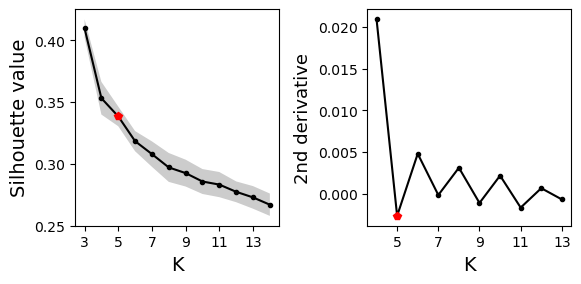

In [131]:
inertia = pred_data["inertia"].reshape([-1, pred_data["nitr"]]) / data.shape[1]
x = pred_data["k"]
m = svals.mean(axis=1)
s = svals.std(axis=1)
nopt = 2 # >= 1

plt.figure(figsize=(6, 3))

plt.subplot(121)
plt.plot(x, m, 'k.-')
plt.fill_between(x, m+s, m-s, color='k', edgecolor="none", alpha=0.2)
plt.xticks(np.arange(x[0], x[-1], 2))
plt.ylabel("Silhouette value", fontsize=14)
plt.xlabel("K", fontsize=14)
plt.plot(x[nopt], m[nopt], "rp")

plt.subplot(122)
m2 = (m[2:] + m[:-2] - 2*m[1:-1]) / 2
plt.plot(x[1:-1], m2, 'k.-')
plt.xticks(np.arange(x[0], x[-1], 2))
plt.ylabel("2nd derivative", fontsize=13)
plt.xlabel("K", fontsize=14)
# plt.ylim([-0.02, 0.3])
plt.plot(x[nopt], m2[nopt-1], "rp")

plt.tight_layout()
plt.savefig("./figs/metric/silhouette%s.png"%(tag), dpi=200)
plt.show()

### Determine with consensus-clustering method

In [125]:
import warnings
warnings.filterwarnings(action='ignore')

@njit 
def build_consensus_matrix(pred_set, sval_set=None):
    
    npoint = pred_set.shape[1]
    N = pred_set.shape[0]
    sval_set = np.ones(N) if sval_set is None else sval_set
    cmat = np.zeros((npoint, npoint))
    
    for n in range(N):
        s = sval_set[n]
        pred = pred_set[n]
        for i in range(npoint):
            cmat[i, i] += s
            for j in range(i+1, npoint):
                if pred[i] == pred[j]:
                    cmat[i, j] += s
                # cmat[j, i] = cmat[i, j]
    
    cmat = cmat / cmat[0, 0]
    for i in range(npoint):
        for j in range(i):
            cmat[i, j] = cmat[j, i]
     
    
    return cmat    

In [126]:
de = 0.05
e = np.arange(-de/2, 1+de, de)

hists = []
nmax = pred_data["nitr"]
for n in trange(len(pred_data["k"])):
    pred_labels = np.array(pred_data["labels"][n*nmax:(n+1)*nmax])
    
    cmat = build_consensus_matrix(pred_labels)
    nbin, _ = np.histogram(cmat, e)
    hists.append(nbin/np.sum(nbin))
    
    del cmat
    
# with open("./data/consensus_clustering_hists.pkl", "wb") as fp:
#     pkl.dump(dict(ksets=np.arange(3, 13), hists=hists, edges=e), fp)    

  0%|          | 0/12 [00:00<?, ?it/s]

kopt=5


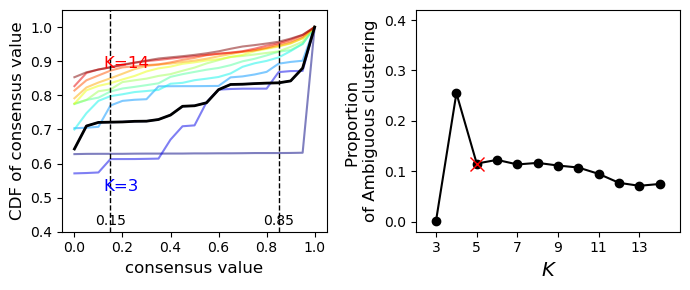

In [142]:
x = (e[1:] + e[:-1])/2
palette = hhtools.get_palette("jet")
ksets = pred_data["k"]

nopt = 2
nx = [3, 17]

pacs = []
for i in range(len(hists)):
    c = np.cumsum(hists[i])
    pacs.append(c[nx[1]] - c[nx[0]])

plt.figure(figsize=(7, 3))
plt.subplot(121)
for i in range(len(hists)):
    plt.plot(x, np.cumsum(hists[i]), c=palette(i/(len(hists)-1)), alpha=0.5)
plt.text(0.12, 0.52, "K=%d"%(ksets[0]), fontsize=12, color="b")
plt.text(0.12, 0.88,  "K=%d"%(ksets[-1]), fontsize=12, color='r')

plt.plot([x[nx]]*2, [0, 1.2], 'k--', lw=1)
plt.plot(x, np.cumsum(hists[nopt]), lw=2, c='k')
plt.xlabel("consensus value", fontsize=12)
plt.ylabel("CDF of consensus value", fontsize=12)
plt.ylim([0.4, 1.05])

for i in range(2):
    plt.text(x[nx[i]], 0.43, "%.2f"%(x[nx[i]]), va="center", ha="center")

plt.subplot(122)
plt.plot(ksets, pacs, 'ko-')
plt.plot(ksets[nopt], pacs[nopt], 'rx', markersize=10)
plt.xlabel("K", fontsize=14, fontstyle="italic")
plt.ylabel("Proportion \nof Ambiguous clustering", fontsize=12)

plt.ylim([-0.02, 0.42])
plt.xlim([2, 15])
plt.xticks(np.arange(3, 15, 2))

print("kopt=%d"%(ksets[nopt]))

plt.tight_layout()
plt.savefig("./figs/metric/consensus_value%s.png"%(tag), dpi=200)
plt.show()

# Run clustering on optimal K

In [135]:
from sklearn.metrics import silhouette_samples

cmat_opt = build_consensus_matrix(pred_data["labels"][nopt*nmax:(nopt+1)*nmax])
dmat = 1 - cmat_opt
dmat[dmat <= 0] = 0

model_tree = hc.SLHC(metric="precomputed", method="average") # complete
model_tree.fit(dmat)

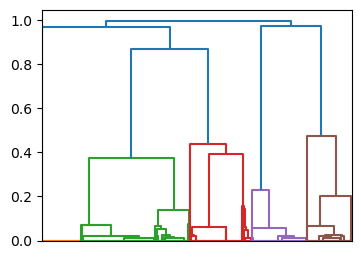

In [136]:
plt.figure(figsize=(4, 3))
model_tree.draw_dend()
plt.show()

In [137]:
# cid_tmp = model_tree.cut_dend(N=ksets[nopt])
cid_tmp = model_tree.cut_dend(dth=0.7)
sq_cid_tmp = np.reshape(cid_tmp, feature_dims)
sq_cid = sq_cid_tmp.copy()

for nr in range(feature_dims[-2]):
    for nw in range(feature_dims[-1]):
        tmp = hc.remove_cluster_island(sq_cid_tmp[:, :, nr, nw], nth=6)
        # tmp2 = hc.remove_cluster_island(tmp, nth=3)
        sq_cid[:, :, nr, nw] = hc.remove_cluster_island(tmp, nth=3)
        # sq_cid[:, :, nr, nw] = hc.remove_cluster_island(tmp, nth=6)
        
sq_cid, id_old2new = hc.reorder_sq_cluster_id(sq_cid, start_id=1)
cid = sq_cid.flatten()
svals = silhouette_samples(data.T, cid, metric="euclidean")

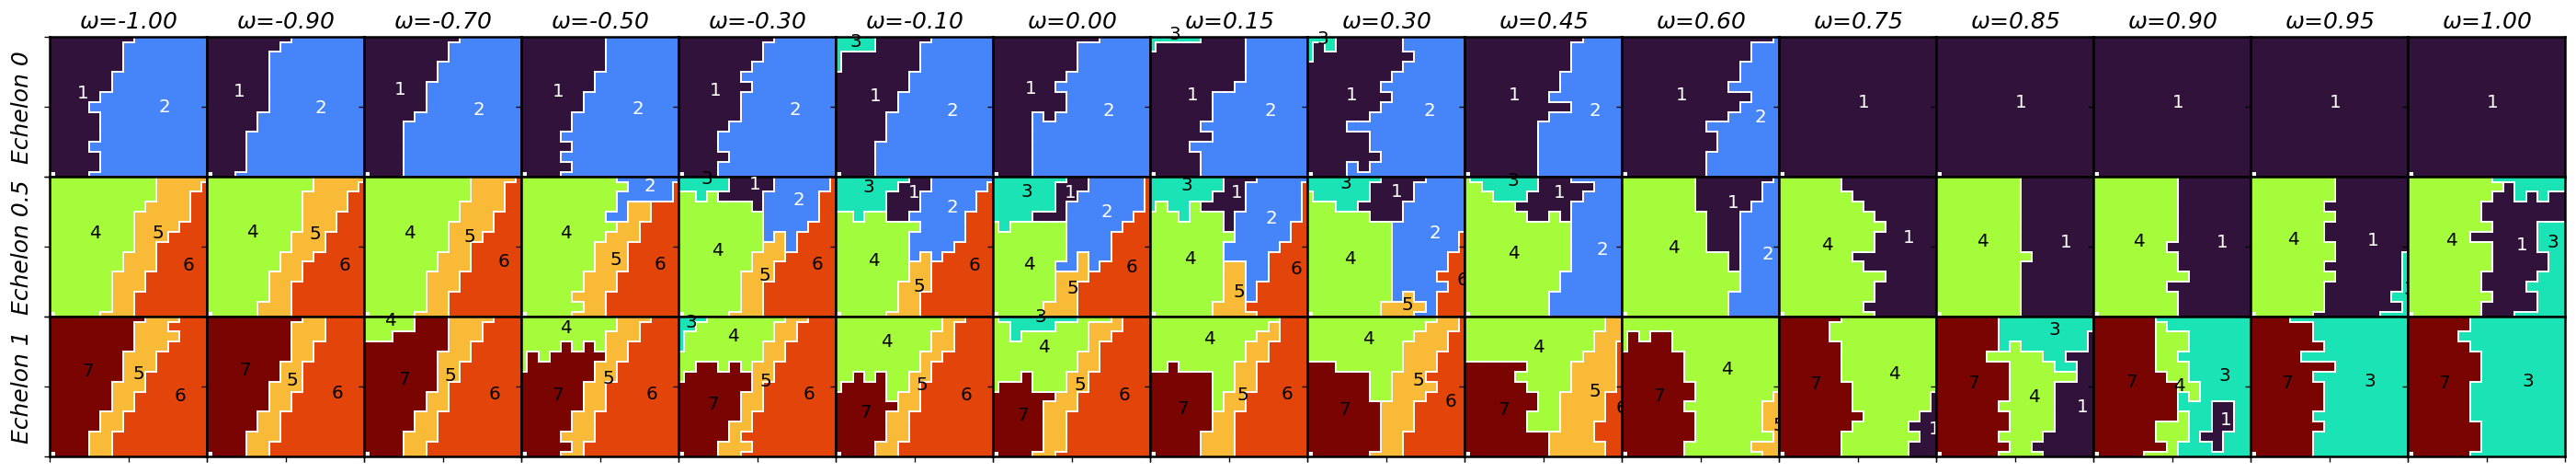

In [242]:
wsets = [-1, -0.9, -0.7, -0.5, -0.3, -0.1, 0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.85, 0.9, 0.95, 1]
fig, axs = hc.show_cluster_summary(sq_cid, wsets=wsets, figsize=(24, 4), min_cid=1, max_cid=7)
# fig, axs = hc.show_cluster_summary(sq_cid, wsets=wsets, figsize=(10, 4), min_cid=1, max_cid=ksets[nopt])
plt.savefig("./figs/clustering_result/cluster_id%s.png"%(tag), bbox_inches="tight")
plt.show()

In [108]:
## Manual adjustment

# id_change = {"1":1, "2":2, "3":9, "4":3, "5":5, "6":8, "7":6, "8":7, "9":4}
# id_change = [-1, 1, 2, 9, 3, 5, 8, 6, 7, 4]
# id_change = [-1, 1, 2, 6, 3, 5, 4, 9, 7, 8]
# id_change = []
# cid_man = cid.copy()
# for i in range(len(id_change)):
#     cid_man[cid == i] = id_change[i]
# cid = cid_man
# sval = silhouette_score(data.T, cid)

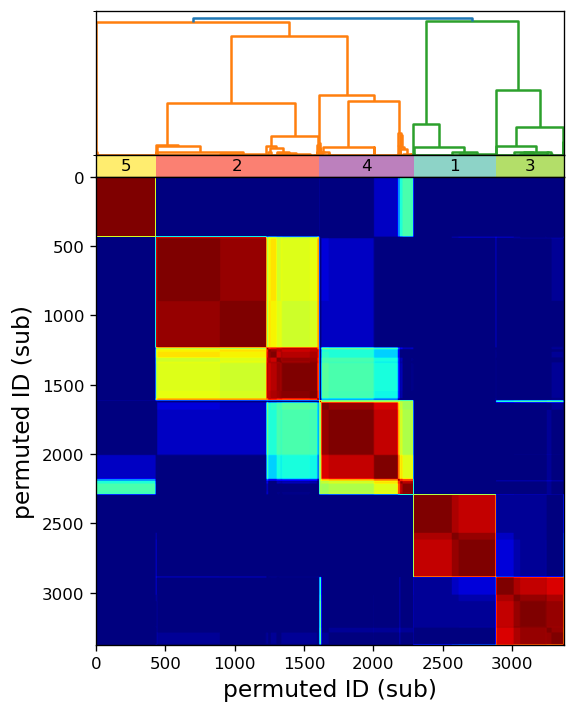

In [140]:
sorted_mat, sort_id = model_tree.sort_dmat(cmat_opt.copy())
# plt.figure(figsize=(5, 3))
fig = hc.draw_with_dendrogram(model_tree.linkmat, sorted_mat, cid_tmp[sort_id], label="permuted ID (sub)")
fig.savefig("./figs/clustering_result/dendrogram%s.png"%(tag))

## Save clustering result

In [143]:
from sklearn.metrics import silhouette_samples, silhouette_score

sval = silhouette_samples(data.T, cid)
scoef = silhouette_score(data.T, cid)

postdata = xa.load_dataarray("../three_pop_mpi/simulation_data/postdata.nc")
# postdata = xa.load_dataarray("../mono_pop_mpi/simulation_data/postdata_slow.nc")

sz = feature_dims
dims = ("alpha", "beta", "rank", "w")
coords = coords=dict(
            alpha=postdata.coords["alpha"].data,
            beta=postdata.coords["beta"].data,
            rank=postdata.coords["rank"].data,
            w=postdata.coords["w"].data
        )

cid_dataset = xa.Dataset(
    data_vars=dict(
        cluster_id=(dims, cid.reshape(*sz)),
        sval=(dims, sval.reshape(*sz))
    ),
    coords=coords,
    attrs=dict(
        id_set=np.unique(cid),
        date=utils.get_date_string(),
        scoef=scoef,
        source="./data/kmeans_sub%s.pkl"%(tag)
    )
)

cid_dataset.to_netcdf("./data/cluster_id_sub%s.nc"%(tag))

In [236]:
cid_dataset.cluster_id

<xarray.DataArray 'cluster_id' (alpha: 15, beta: 15, rank: 3, w: 16)>
array([[[[1., 1., 1., ..., 1., 1., 1.],
         [4., 4., 4., ..., 4., 4., 4.],
         [7., 7., 7., ..., 7., 7., 7.]],

        [[1., 1., 1., ..., 1., 1., 1.],
         [4., 4., 4., ..., 4., 4., 4.],
         [7., 7., 7., ..., 7., 7., 7.]],

        [[1., 1., 1., ..., 1., 1., 1.],
         [4., 4., 4., ..., 4., 4., 4.],
         [7., 7., 7., ..., 7., 7., 7.]],

        ...,

        [[2., 2., 2., ..., 1., 1., 1.],
         [6., 6., 6., ..., 1., 3., 3.],
         [6., 6., 6., ..., 3., 3., 3.]],

        [[2., 2., 2., ..., 1., 1., 1.],
         [6., 6., 6., ..., 1., 3., 3.],
...
         [4., 4., 4., ..., 4., 4., 4.],
         [7., 7., 4., ..., 7., 7., 7.]],

        [[1., 1., 1., ..., 1., 1., 1.],
         [4., 4., 4., ..., 4., 4., 4.],
         [7., 7., 4., ..., 7., 7., 7.]],

        ...,

        [[2., 2., 2., ..., 1., 1., 1.],
         [5., 5., 5., ..., 1., 1., 3.],
         [6., 6., 6., ..., 3., 3., 3.]],

        [[2., 2., 2., ..., 1., 1., 1.],
         [5., 5., 5., ..., 1., 1., 3.],
         [6., 6., 6., ..., 3., 3., 3.]],

        [[2., 2., 2., ..., 1., 1., 1.],
         [5., 5., 6., ..., 1., 1., 3.],
         [6., 6., 6., ..., 3., 3., 3.]]]])
Coordinates:
  * w        (w) float64 -1.0 -0.9 -0.7 -0.5 -0.3 ... 0.75 0.85 0.9 0.95 1.0
  * alpha    (alpha) float64 0.0 0.1429 0.2857 0.4286 ... 1.571 1.714 1.857 2.0
  * beta     (beta) float64 0.0 0.07143 0.1429 0.2143 ... 0.8571 0.9286 1.0
  * rank     (rank) float64 0.0 0.5 1.0

In [171]:
cid_dataset = xa.load_dataset("./data/cluster_id_sub.nc")

data = align_data_sub["data"].copy()
cid = cid_dataset.cluster_id.data.flatten()
sval = cid_dataset.sval.data.flatten()

In [195]:
data_order = np.zeros_like(data)

num_cluster = []
n0 = 0
for nk in range(1, 8):
    is_target = cid==nk
    data_sub = data[:, is_target]
    sval_sub = sval[is_target]
    
    num = np.sum(is_target)
    id_order = np.argsort(sval_sub)[::-1]
    data_order[:, n0:n0+num] = data_sub[:, id_order]
    n0 = n0 + num
    num_cluster.append(num)
    
# smoothing over row
from scipy.signal import savgol_filter

for n in range(data_order.shape[0]):
    x = savgol_filter(data_order[n], 10, 2)
    data_order[n] = x

In [ ]:
plt.figure(figsize=(7, 3.3))
plt.imshow(data_order.T, aspect="auto", cmap="jet", vmin=-2, vmax=2, interpolation="None")

xl = plt.xlim()
n0 = 0
for nk in range(1, 8):
    y0 = n0 + num_cluster[nk-1]/2
    plt.text(17.5, y0, "Regime %d"%(nk), ha="center", va="center", fontsize=12)
    
    n0 += num_cluster[nk-1]
    plt.hlines(n0, xl[0], xl[1], color='k')

plt.ylim([0, data.shape[1]])
plt.colorbar(ticks=np.arange(-2, 2.1, 1), shrink=0.5)
plt.xticks(np.arange(data.shape[0]), labels=align_data_sub["row_labels"], rotation=45, fontsize=9)

plt.yticks([])
plt.ylabel("Set of structure\nparameters", fontsize=13)

plt.show()

In [161]:
align_data_sub["data"].shape

(20, 10800)

# Find representative points

## Tune the number of points

In [105]:
target_cid = 1

N = np.sum(cid == target_cid)
sq_cid = cid.reshape(feature_dims)
sq_sval = sval.reshape(feature_dims)

idx_target = np.array(np.where(sq_cid==target_cid))
sval_target = np.array(sval[cid==target_cid])

# sort
id_sort = np.argsort(sval_target)[::-1]
idx_target = idx_target[:, id_sort]
sval_target = sval_target[id_sort]
sval_target[sval_target <= 0] = 0

dist = []
x = []
hist_cid = []
hist_idc = []
sval_ratio = []
prev_idc = idx_target[:, 0]
for nb in np.arange(1, N, 50):
    idx_sub = idx_target[:, :nb]
    sval_sub = sval_target[:nb]
    
    w = sval_sub / sval_sub.sum()
    idx_center = (idx_sub * w).sum(axis=1)
    d = np.sqrt(((idx_target - idx_center[:, None])**2).sum(axis=0))
    idc = idx_target[:, np.argmin(d)]
    
    x.append(nb)
    dist.append(np.sqrt(np.sum((idc - prev_idc)**2)))
    hist_idc.append(idc)
    hist_cid.append(sq_cid[*idc])
    sval_ratio.append(sq_sval[*idc] / sval_target[0])
    prev_idc = idc
    
hist_idc = np.array(hist_idc)
hist_cid = np.array(hist_cid)
sval_ratio = np.array(sval_ratio)

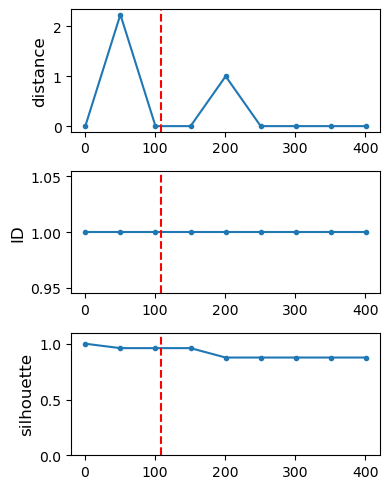

In [106]:
def draw_indicator():
    yl = plt.ylim()
    plt.plot([x0]*2, yl, 'r--')
    plt.ylim(yl)

x0 = N * 0.25

plt.figure(figsize=(4, 5))

plt.subplot(311)
plt.plot(x, dist, '.-')
plt.ylabel("distance", fontsize=12)
draw_indicator()

plt.subplot(312)
plt.plot(x, hist_cid, '.-')
plt.ylabel("ID", fontsize=12)
draw_indicator()

plt.subplot(313)
plt.plot(x, sval_ratio, '.-')
plt.ylabel("silhouette", fontsize=12)
plt.ylim([0, 1.1])
draw_indicator()

plt.tight_layout()
plt.show()

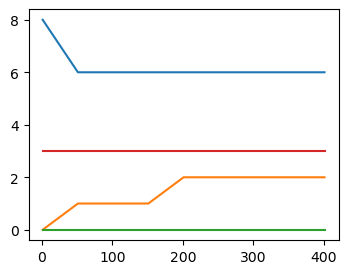

In [107]:
plt.figure(figsize=(4, 3))
plt.plot(x, hist_idc[:, 0])
plt.plot(x, hist_idc[:, 1])
plt.plot(x, hist_idc[:, 2])
plt.plot(x, hist_idc[:, 3])
plt.show()

## Take the representative points

In [246]:
sq_sval = cid_dataset.sval.data

In [247]:
ratio = 0.25
repr_sval = []
repr_idx = []
repr_params = []

for target_cid in range(1, int(cid.max())+1):
    
    idx_target = np.array(np.where(sq_cid==target_cid))
    sval_target = np.array(sval[cid==target_cid])
    id_sort = np.argsort(sval_target)[::-1]
    idx_target = idx_target[:, id_sort]
    sval_target = sval_target[id_sort]
    sval_target[sval_target <= 0] = 0
    
    nb = int(len(sval_target) * ratio)
    w = sval_target[:nb] / sval_target[:nb].sum()
    idx_sub = idx_target[:,:nb]
    
    x0 = (idx_sub * w).sum(axis=1)
    d = np.sqrt(((idx_target - x0[:, None])**2).sum(axis=0))
    idc = idx_target[:, np.argmin(d)]
    
    s = sq_sval[*idc] / sval_target.max()
    
    repr_sval.append(s)
    repr_idx.append(idc)
    
    
# add 3-control cases
repr_sval.extend([0,0,0])
repr_idx.append([0,0,0,0])
repr_idx.append([0,0,1,0])
repr_idx.append([0,0,2,0])
repr_idx = np.array(repr_idx)

cluster_id = np.concatenate([np.unique(cid), [-1, -2, -3]])

for idc in repr_idx:
    repr_params.append([postdata.coords["alpha"].data[idc[0]],
                        postdata.coords["beta"].data[idc[1]],
                        postdata.coords["rank"].data[idc[2]],
                        postdata.coords["w"].data[idc[3]]])


In [ ]:
repr_idx

In [149]:
data = dict(
    repr_idx=repr_idx,
    repr_params=repr_params,
    repr_sval=repr_sval,
    ratio=ratio,
    cluster_id=cluster_id,
    cluster_fname="./data/cluster_id_sub%s.nc"%(tag)
)
    
with open("./data/cluster_repr_points%s.pkl"%(tag), "wb") as fp:
    pkl.dump(data, fp)

In [150]:
repr_idx

array([[ 2,  5,  0,  2],
       [10,  9,  0,  1],
       [12,  4,  1,  1],
       [ 8,  9,  2,  2],
       [ 4,  7,  1,  2],
       [ 0,  0,  0,  0],
       [ 0,  0,  1,  0],
       [ 0,  0,  2,  0]])

In [151]:
data["repr_params"]

[[0.285714, 0.357143, 0.0, 0.5],
 [1.428571, 0.642857, 0.0, 0.25],
 [1.714286, 0.285714, 0.5, 0.25],
 [1.142857, 0.642857, 1.0, 0.5],
 [0.571429, 0.5, 0.5, 0.5],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.5, 0.0],
 [0.0, 0.0, 1.0, 0.0]]

## Check dynamics features

In [58]:
import hhtools
import hhsignal

fdir = "../three_pop_mpi/simulation_data/data/"
summary_obj = hhtools.SummaryLoader(fdir, load_only_control=True)

In [64]:
# alpha, beta, echelon, w, ntrial
# loc_points = ((14, 0, 0, 5),
#               (14, 0, 1, 6),
#               ( 5,10, 2, 15))
loc_points = repr_idx[:-3]
markers = ("o", "x", "<", "p")
N = len(loc_points)

In [65]:
sval_sq = (svals - svals.min())/(svals.max() - svals.min())
sval_sq = sval_sq.reshape(feature_dims)

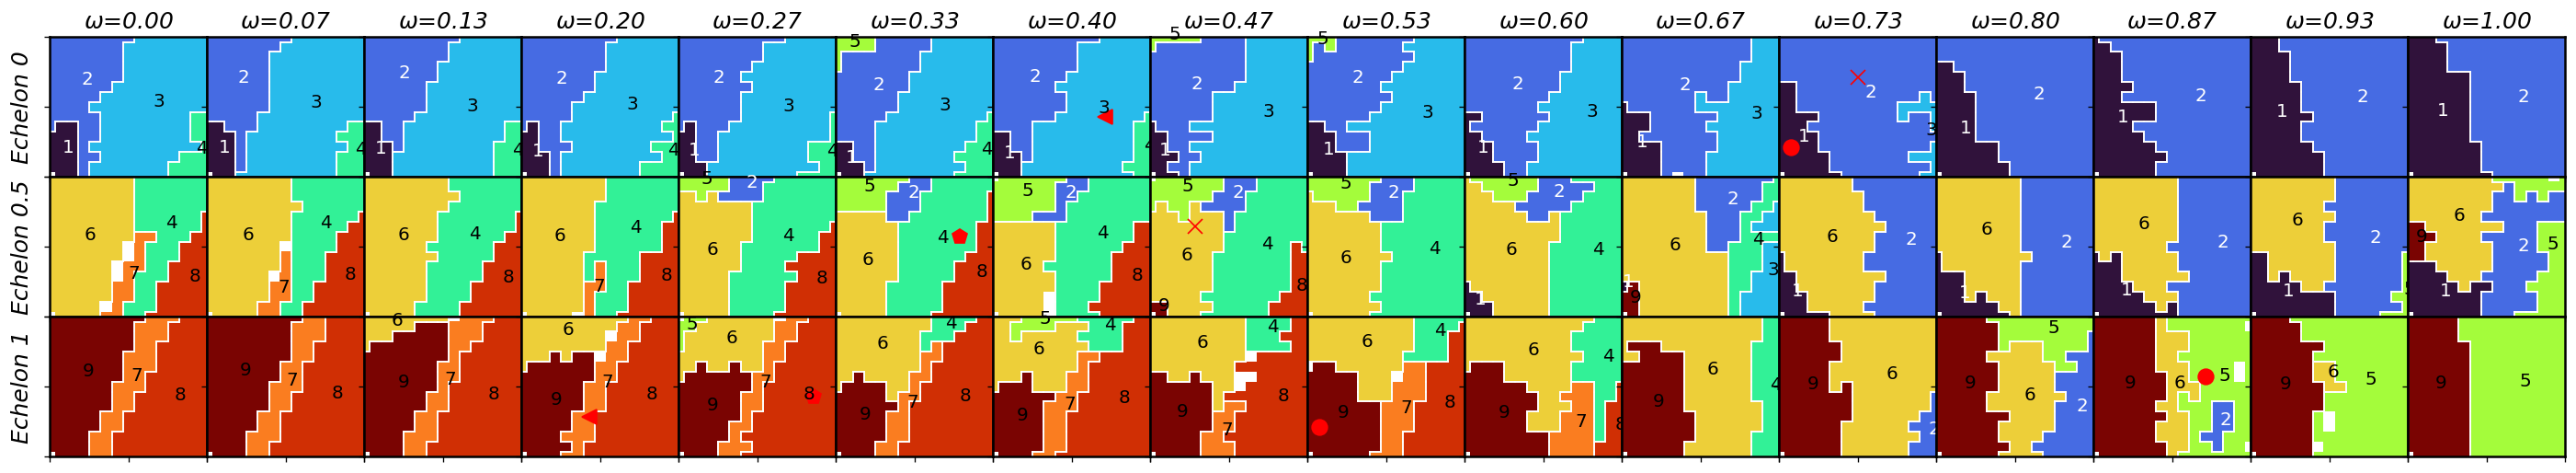

In [66]:
wsets = [-1, -0.9, -0.7, -0.5, -0.3, -0.1, 0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.85, 0.9, 0.95, 1]
fig, axs = hc.show_cluster_summary(sq_cid, wsets=np.linspace(0, 1, feature_dims[-1]), figsize=(24, 4), min_cid=1, max_cid=ksets[nopt], sval=sval_sq)
for n in range(N):
    na, nb, nr, nw = loc_points[n]
    ax = axs[nw][nr]
    ax.plot(nb, na, marker=markers[n%4], color="r", markersize=10)
plt.show()

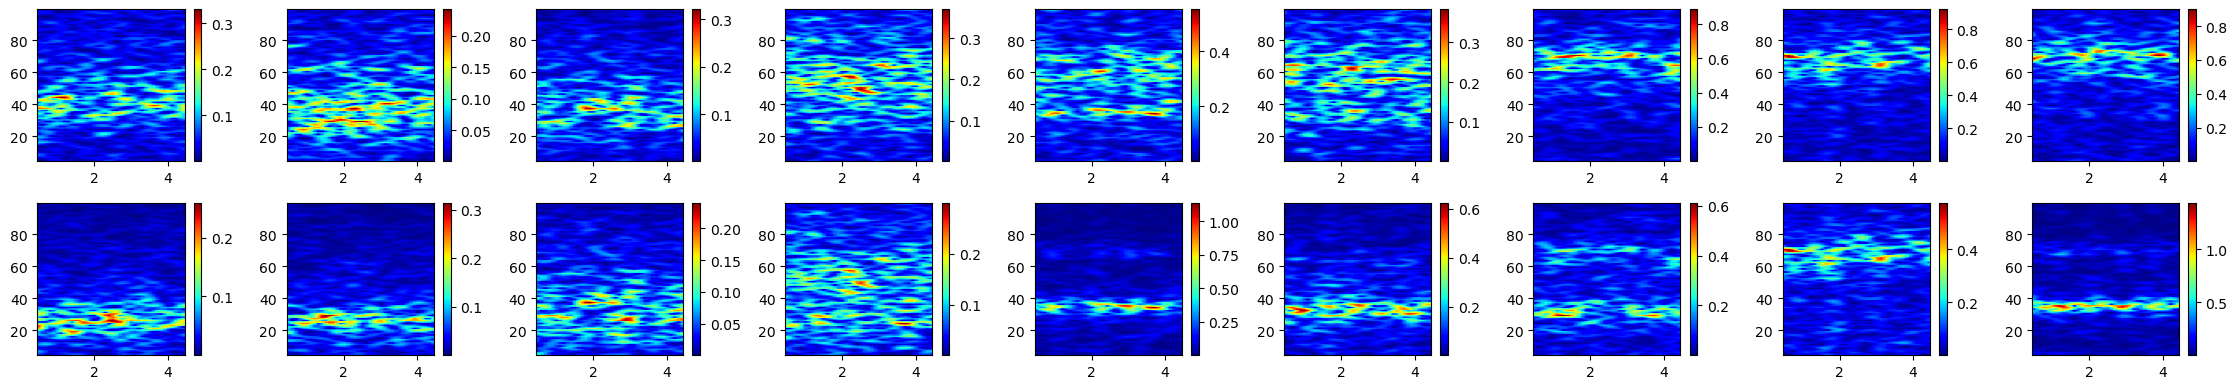

In [67]:
# get psd
psd_set = [] 
for n in range(N):
    detail = summary_obj.load_detail(*loc_points[n], 0)
    t = detail["ts"]
    
    # compute_psd_set
    psd_set.append([])
    for ntp in range(1, 3):
        v = detail["vlfp"][ntp]
        psd, fpsd, tpsd = hhsignal.get_stfft(v, t, 2000, frange=(5, 100))
        idt = (tpsd >= 0.5)
        psd = psd[:,idt]
        # psd = (psd - psd.mean(axis=1, keepdims=True))/psd.std(axis=1, keepdims=True)
        psd_set[-1].append(psd[:, idt])
        
psd_set = np.array(psd_set)        
tpsd = tpsd[idt]

fig, axs = plt.subplots(2, N, figsize=(2.5*N, 4), dpi=100)
for n in range(N):
    for i in range(2):
        plt.sca(axs[i][n])
        hhtools.imshow_xy(psd_set[n][i], x=tpsd, y=fpsd, cmap="jet")
        plt.colorbar()
        
plt.tight_layout()
plt.show()

## Check cluster features

In [160]:
target_cid = 4

features = align_data_sub["data"][:, cid==target_cid]

4: 0.1011
4: -0.3510
4: 0.3918


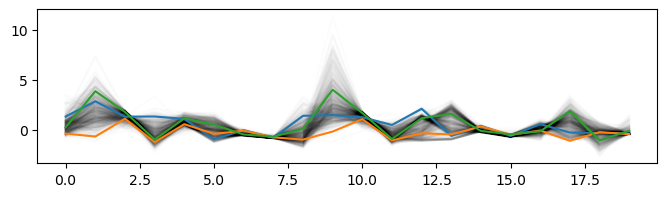

In [163]:
plt.figure(figsize=(8, 2))

for n in range(features.shape[1]):
    plt.plot(features[:,n], color='k', alpha=0.01)
    
for n in range(N):
    nid = hhtools.get_id((15, 15, 3, 16), *loc_points[n])
    plt.plot(align_data_sub["data"][:,nid], alpha=1)
    print("%d: %.4f"%(cid[nid], svals[nid]))
plt.show()

## Compare with previous cluster ID

In [592]:
prev_cid_sub = xa.load_dataset("./data/xdata/cluster_id_sub.nc")
prev_cid = prev_cid_sub.cluster_id.data.flatten()

In [593]:
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

print(adjusted_mutual_info_score(prev_cid, cid))
print(adjusted_rand_score(prev_cid, cid))

0.726860252997889
0.6633156778257547


### Show contingency table

In [613]:
# @jit(nopython=True)
def gen_contingency_mat(cluster_id1, cluster_id2, sval1=None, sval2=None, sth=0.2):
    
    cid_set1 = np.sort(np.unique(cluster_id1)).astype(int)
    cid_set2 = np.sort(np.unique(cluster_id2)).astype(int)
    cont_mat = np.zeros((len(cid_set1), len(cid_set2)))
    
    N = len(cluster_id1)    
    for n in range(N):
        s1 = sval1[n] if sval1 is not None else 1
        s2 = sval2[n] if sval2 is not None else 1
        if s1 > sth and s2 > sth:
            c1 = int(cluster_id1[n]) - cid_set1[0]
            c2 = int(cluster_id2[n]) - cid_set2[0]
            cont_mat[c1, c2] += 1
    
    return cont_mat, cid_set1, cid_set2


def draw_contingency_table(cont_mat, cid_set1, cid_set2, cid_labels, norm=False):
    def imshow_auto(im, **kwargs):
        plt.imshow(im, aspect="auto", **kwargs)
        
    def write_num(arr, dir="v"):
        for n, a in enumerate(arr):
            if dir == "v":
                plt.text(0, n, "%d"%(a), fontsize=14, ha="center", va="center")
            elif dir == "h":
                plt.text(n, 0, "%d"%(a), fontsize=14, ha="center", va="center")
                
    N = np.sum(cont_mat)
    
    ax_cont = plt.axes([0.1, 0.1, 0.7, 0.7])
    if norm:
        norm_cont_mat = cont_mat / cont_mat.sum(axis=1, keepdims=True)
        imshow_auto(norm_cont_mat, cmap="gray", vmax=1, vmin=0)
    else:
        vmax = N/np.max([len(np.unique(cid_set1)), len(np.unique(cid_set2))])
        imshow_auto(cont_mat, cmap="gray", vmax=vmax, vmin=0)
    plt.xticks(np.arange(len(cid_set2)), labels=cid_set2)
    plt.yticks(np.arange(len(cid_set1)), labels=cid_set1)
    plt.ylabel("cluster ID (%s)"%(cid_labels[0]), fontsize=14)
    plt.xlabel("cluster ID (%s)"%(cid_labels[1]), fontsize=14)
    
    ax_sum1 = plt.axes([0.82, 0.1, 0.1, 0.7]) # right axis
    cont_sum1 = np.reshape([np.sum(cont_mat[nr, :]) for nr in range(len(cid_set1))], (-1, 1))
    imshow_auto(cont_sum1, vmin=0, cmap="jet")
    write_num(cont_sum1.flatten(), dir="v")
    plt.yticks([])
    plt.xticks([])
    
    ax_sum2 = plt.axes([0.1, 0.82, 0.7, 0.1]) # upper axis
    cont_sum2 = np.reshape([np.sum(cont_mat[:, nc]) for nc in range(len(cid_set2))], (1, -1))
    imshow_auto(cont_sum2, vmin=0, cmap="jet")
    write_num(cont_sum2.flatten(), dir="h")
    plt.yticks([])
    plt.xticks([])
    
    plt.axes([0.82, 0.82, 0.1, 0.1]) # corner (sum)
    plt.xlim([0, 1]); plt.ylim([0, 1])
    # plt.xticks([]); plt.yticks([])
    plt.text(0.5, 0.5, "%d"%(N), fontsize=14, va='center', ha='center')
    plt.axis("off")


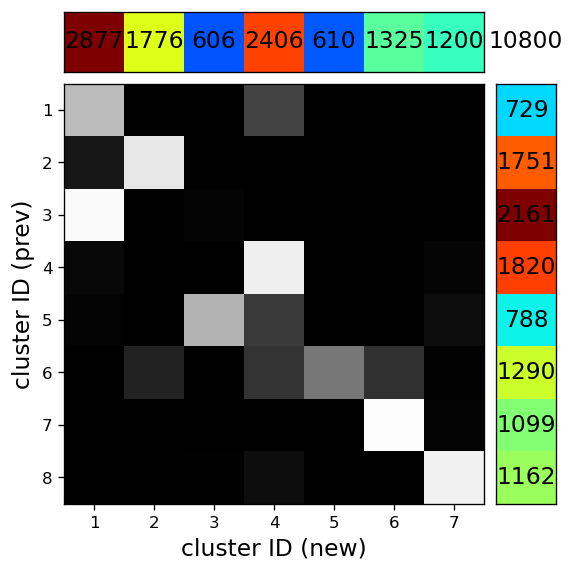

In [615]:
cont_mat, cid_set_prev, cid_set = gen_contingency_mat(prev_cid, cid)
# norm_cont_mat = cont_mat / 

plt.figure(dpi=120, figsize=(5, 5))
draw_contingency_table(cont_mat, cid_set_prev, cid_set, ["prev", "new"], norm=True)
# draw_contingency_table(cont_mat, cid_set_sub, cid_set_tot, ["sub", "tot"])
# utils.save_fig("contingency_matrix", fdir="./fig")
plt.show()

### Show clustering result on parameter space

In [91]:
# get lines
def get_im_boundary(im):
    nb = im.shape[0]
    lines = []
    
    def is_out(nr, nc):
        return (nc < 0) or (nc >=nb) or (nr < 0) or (nr >= nb)
    
    for i in range(nb):
        for j in range(nb):
            for d in ((-1, 0), (1, 0), (0, -1), (0, 1)):
                r, c = i+d[0], j+d[1]
                if is_out(r, c): continue
                
                if im[i, j] != im[r, c]:
                    if d[1] == 0:
                        lines.append([[j-0.5, j+0.5], [i+0.5*d[0], i+0.5*d[0]]])
                    else:
                        lines.append([[j+0.5*d[1], j+0.5*d[1]], [i-0.5, i+0.5]])
    return lines


def show_cluster_summary(cluster_id, wsets=None, max_cid=15, min_cid=1, sval=None, sth=0.2):
    
    num_w = 16
    num_r = 3
    
    len_p = 0.95/num_w
    len_r = 0.95/num_r

    xy = np.arange(15)

    lb_rank = ("Echelon 0", "Echelon 0.5", "Echelon 1")
    # lb_w = [r"$\omega$=%.1f"%(x) for x in np.linspace(0.1, 1, 7)]
    # lb_w = [r"$\omega$=%.1f"%(x) for x in np.linspace(0.1, 1, 7)]
    lb_w = [r"$\omega$=%.2f"%(x) for x in wsets]
    
    lines_cluster = []
    for idp in range(num_w):
        for idr in range(num_r):
            lines_cluster.append(get_im_boundary(cluster_id[:, :, idr, idp]))

    ax_sets = []
    # fig = plt.figure(dpi=120, figsize=(14, 6))
    fig = plt.figure(dpi=120, figsize=(20, 4))
    for idp in range(num_w):
        ax_sets.append([])
        for idr in range(num_r):
            ax = plt.axes(position=[0.025+len_p*idp, 0.025+(2-idr)*len_r, len_p, len_r])
            ax_sets[-1].append(ax)
            
            # im = cluster_data["im_stacks"][idr][idp].astype(float)
            im = cluster_id[:, :, idr, idp].astype(float)
            im[0, 0] = np.nan
            
            if sval is not None:
                im[sval[:, :, idr, idp] < sth] = np.nan
            
            hc.show_sq_cluster(im, x=xy, y=xy, cmap="turbo", cth=2, vmin=min_cid, vmax=max_cid, fontsize=12, aspect="auto")
            for l in lines_cluster[idp*num_r+idr]:
                plt.plot(l[0], l[1], 'w', lw=1)
            
            plt.xticks([0, 7, 14], labels=["", "", ""])
            plt.yticks([0, 7, 14], labels=["", "", ""])
            plt.xlim([-0, 14]); plt.ylim([0, 14])
            
            if idp == 0:
                plt.ylabel(lb_rank[idr], fontsize=15, style="italic")
            
            if idr == 0:
                plt.title(lb_w[idp], fontsize=15, style="italic")
            
            for n, k in enumerate(("left", "right", "bottom", "top")):
                ax.spines[k].set_color("k")
                ax.spines[k].set_linewidth(1.5)

    # plt.show()
    return fig, ax_sets

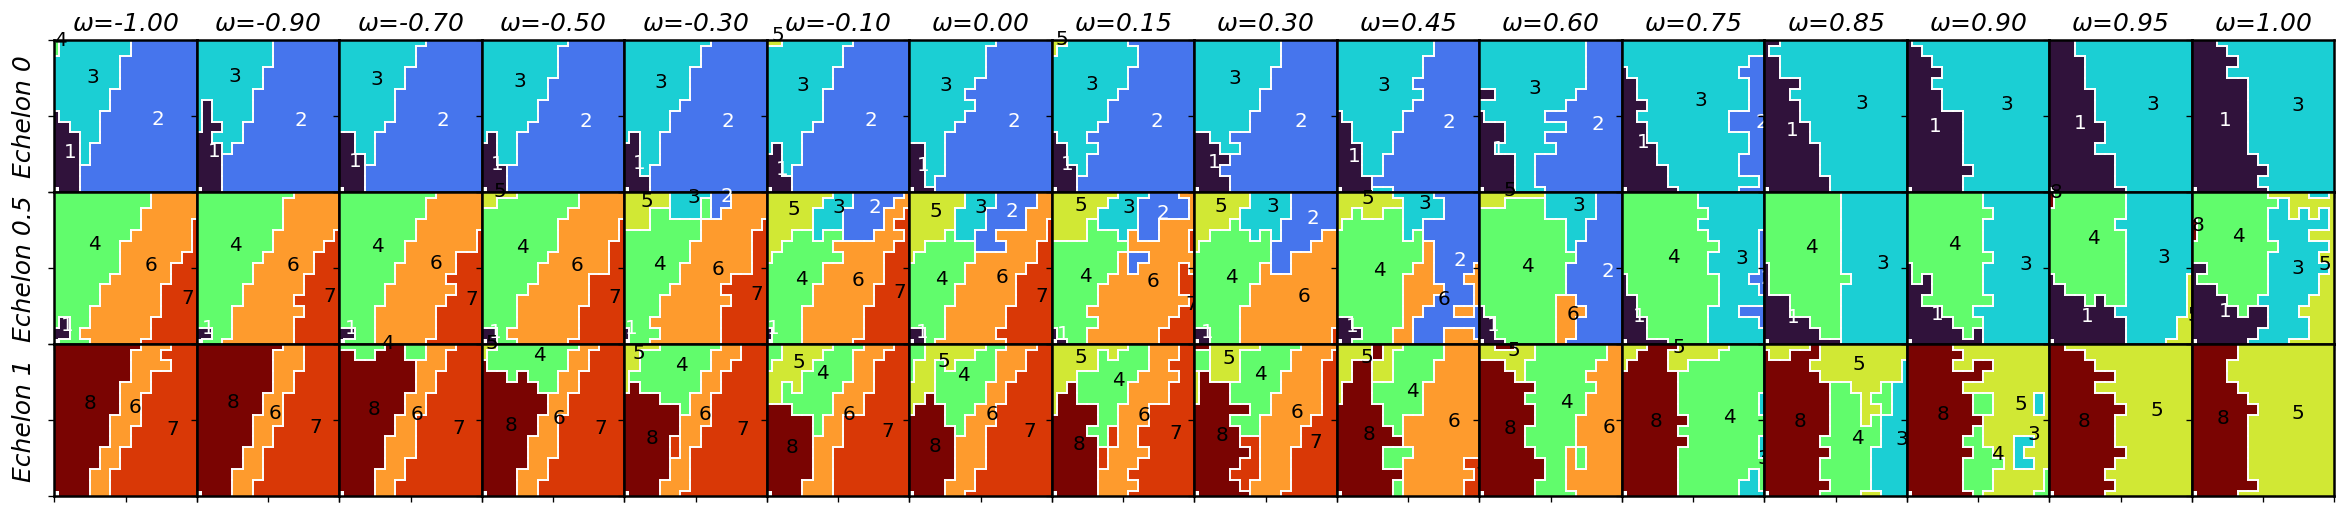

In [37]:
# wsets = prev_cid_sub.coords["w"]
wsets = [-1, -0.9, -0.7, -0.5, -0.3, -0.1, 0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.85, 0.9, 0.95, 1]
show_cluster_summary(np.reshape(prev_cid, (15, 15, 3, 16)), wsets=wsets, max_cid=8)
plt.show()

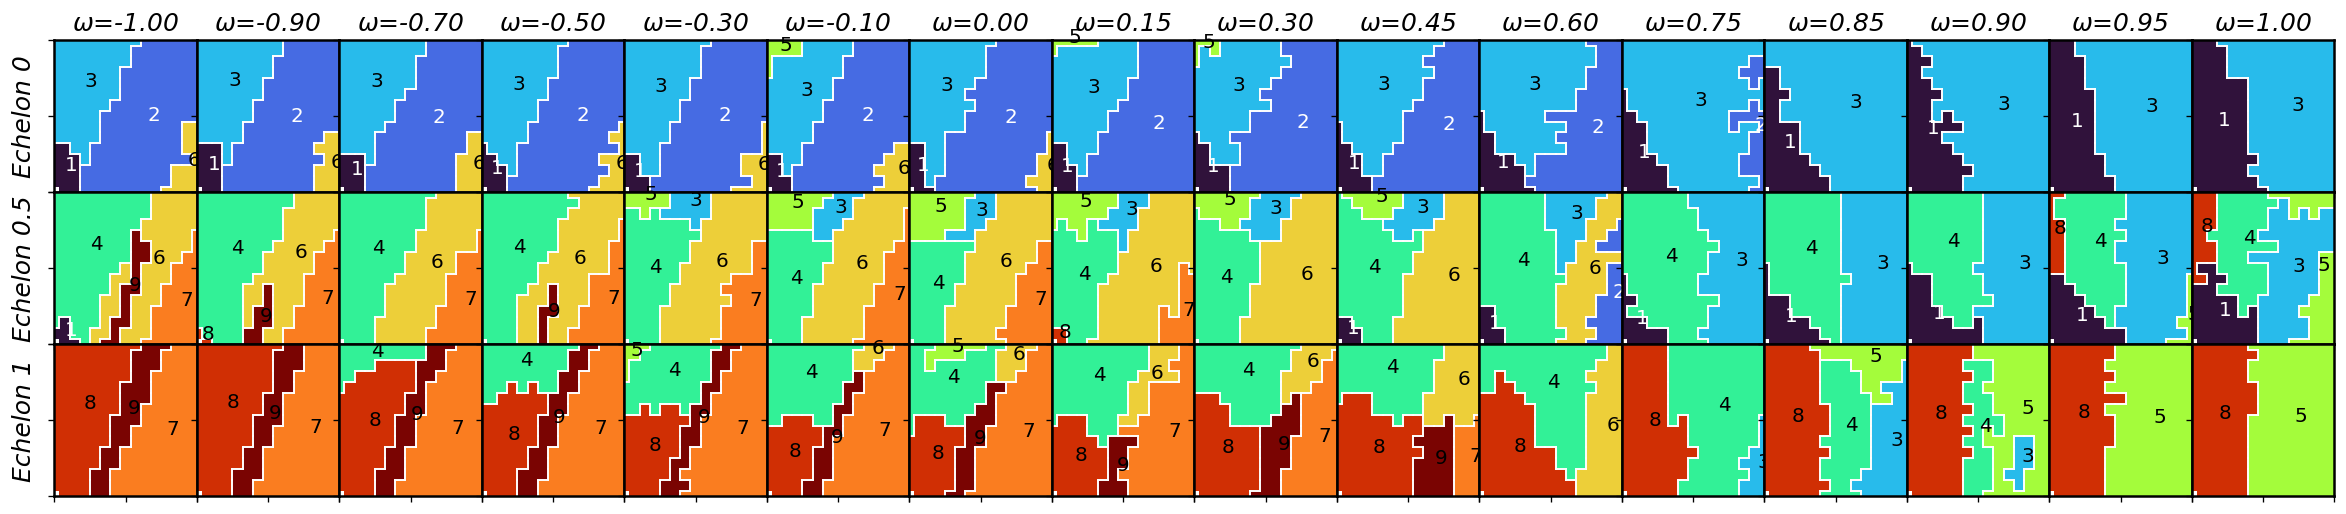

In [122]:
# wsets = prev_cid_sub.coords["w"]
wsets = [-1, -0.9, -0.7, -0.5, -0.3, -0.1, 0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.85, 0.9, 0.95, 1]
show_cluster_summary(np.reshape(cid, (15, 15, 3, 16)), wsets=wsets, max_cid=9)
plt.show()

# Show average feature value

In [152]:
def get_base_idx(ne):
    return 16*ne + np.arange(16)


data_partial = align_data_sub["data"][:-2, :]
lb_partial = align_data_sub["row_labels"][:-2]
N = len(lb_partial)

labels = cid_dataset.cluster_id.data.flatten()

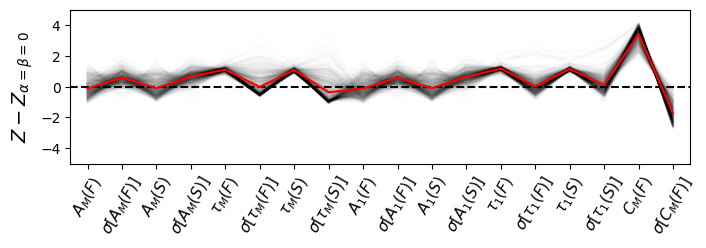

In [142]:
target_cid = 1
num_echelon, _ = np.histogram(echelon[cid == target_cid], [0, 1, 2, 3])
num_echelon_dom = np.argmax(num_echelon)
data_base = data_partial[:, get_base_idx(num_echelon_dom)].mean(axis=1)

plt.figure(figsize=(8, 2))
pobj = plt.plot(data_partial[:, cid==target_cid]-data_base[:, None], 'k', alpha=0.01)
pobj_mean, = plt.plot(data_partial[:, cid==target_cid].mean(axis=1)-data_base, 'r')
plt.plot([-0.5, N-0.5], [0, 0], 'k--', zorder=-1)
plt.xticks(np.arange(N), lb_partial, rotation=60, fontsize=11)
plt.ylim([-5, 5])
plt.xlim([-0.5, N-0.5])
plt.ylabel(r"$Z - Z_{\alpha=\beta=0}$", fontsize=14)
plt.show()